In [1]:
from mydataset.e3sm_seq import Climate240
from models.CDC import compress_modules_2d as compress_modules
import torch
import torch.nn as nn

import importlib
importlib.reload(compress_modules)
from models.CDC import compress_modules_2d as compress_modules
# results_folder = "./results/VD2_InstRange2Norm_4_16_E3SM64_OriginalDomain"

data_arg = {"data_path":"/blue/ranka/xiao.li/dataset/climate_dataset/dataset_numpy",
                        "var": [0,1,2,3,4],
                        "seq": [8],
                        "n_frame":16,
                        "downsampling":1,
                        "input_size":256,"inst_norm": False, "norm_type":'range'}

# dataset_arg = {"data_path":"./data", "n_frame":16, "inst_norm": True, "norm_type":'range2'}

dataset_org = Climate240(data_arg)


pretrain = "./snapshots/MaskedAE/NoMask/model_bs16_ep500k.pt"
# pretrain =  "./snapshots/S3D/s3d_300_200length_endbeta_0.0002/model_bs32_ep200k_final.pt"
# args.pretrain = "./snapshots/MaskedAE/test/model_bs16_ep500k_final.pt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


modelAE = compress_modules.ResnetCompressor(  dim= 16,
                                            dim_mults=[1,2,3,4],
                                            reverse_dim_mults=[4,3,2,1],
                                            hyper_dims_mults=[4,4,4],
                                            channels = 1,
                                            out_channels = 1,
                                            d3=True)

if pretrain != "":
    print("Load pretrain model:", pretrain)
    state_dict = torch.load(pretrain, map_location=device)
    modelAE.load_state_dict(state_dict)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    modelAE = nn.DataParallel(model)  # Wrap model with DataParallel for multi-GPU
else:
    print("Using a single GPU!")


modelAE = modelAE.to(device).eval()


import importlib
import models

def load_matching_parameters(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)["ema"]
    model_dict = model.state_dict()
    pretrained_dict = {
        k: v for k, v in checkpoint.items() 
        if k in model_dict and model_dict[k].shape == v.shape
    }

    # Update model's state dict
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict, strict=False)
    

# importlib.reload(models)
# importlib.reload(models.video_diffusion_interpo.Unet3D)
# importlib.reload(models.video_diffusion_interpo.GaussianDiffusion)




/apps/pytorch/2.2.0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


*************** Loading E3SM ***************
*************** Loading /blue/ranka/xiao.li/dataset/climate_dataset/dataset_numpy/08.npz ***************
Original Data Shape: (5, 6, 720, 240, 240)
self.data_input: (5, 6, 720, 240, 240)
Load pretrain model: ./snapshots/MaskedAE/NoMask/model_bs16_ep500k.pt
Using a single GPU!


In [12]:
2430* 1* 16*64* 64*4/0.91374/1e9

0.6971457088449668

In [9]:
720*6*256*256/0.91/1e9*8

2.4889276483516483

In [1]:
350/80

4.375

In [2]:
import torch
import torch.nn.functional as F

def interpolate_along_n(x, scale_factor=3):
    # x: [B, N, C, W, H]
    B, N, C, W, H = x.shape

    # Permute to [B, C, N, W, H] to treat N as a temporal/spatial dim


    # Interpolate along dim=2 (N) with linear mode for 3D input
    x = F.interpolate(x, scale_factor=(scale_factor, 1, 1), mode='trilinear', align_corners=False)

    return x

In [21]:
from models.video_diffusion_interpo import Unet3D, GaussianDiffusion
# from models.video_diffusion_rcond import Unet3D, GaussianDiffusion,tokenize,bert_embed
import torch


timesteps = 8


model = Unet3D(
    dim = 64,
    out_dim = 64,
    channels = 64,
    dim_mults = (1, 2, 4, 8),
    use_bert_text_cond = False
)

diffusion = GaussianDiffusion(
    model,
    image_size = 16,
    num_frames = -1,
    channels = 64,
    timesteps = timesteps,   # number of steps
    loss_type = 'l2'    # L1 or L2
).cuda()


# data = torch.load("./results/VD_Latent_InstRange2Norm_16_e3sm100_pretrain_t50/model-300.pt")
# diffusion.load_state_dict(data['ema'])
path2 = "./results/VD_Latent_InstRange2Norm_16_e3sm100_pretrain_t50/model-499.pt"

path = "./results/VD_Latent_InstRange2Norm_16_e3sm100_pretrain/model-499.pt"
path_rand = "./results/E3SM_Ablation_Timesteps/VD_Latent_interpo_3_t%d/model-20.pt"%(timesteps)
# path_rand = "./results/E3SM_prediction/VD_Latent_interpo_0_t%d_first5/model-29.pt"%(timesteps)

# load_matching_parameters(diffusion, path_rand)

In [22]:
import torch
torch.arange(0,16,3)

tensor([ 0,  3,  6,  9, 12, 15])

In [23]:
# from models.video_diffusion_interpo import GaussianDiffusion, Unet3D, Trainer
# from mydataset.e3sm_latent import ClimateLatent
# from tools_online.io.json_io import save_json

# results_folder = "./results/VD_Latent_InstRange2Norm_16_e3sm100_pretrain_t200"
# dataset_arg = {"data_path":"./data/e3sm100", "n_frame":16, "inst_norm": True, "norm_type":'range2'}

# dataset = ClimateLatent(dataset_arg)
interpo_rate = 3
cond_idx = torch.arange(0,16,interpo_rate)
max_index = cond_idx[-1].item()
valid_mask = ~torch.isin(torch.arange(16), cond_idx)
valid_mask[max_index:] = False
    
overlap = 16 - max_index
extra_frame = ((720 - 16)//(16- overlap)+1) * (16- overlap) + 16 - 720

interpo_rate, overlap, extra_frame

diffusion.num_frames = 16- len(cond_idx)

In [24]:
# cond_idx = torch.LongTensor([0,1,2,3,4,5])
# max_index = cond_idx[-1].item()
# valid_mask = ~torch.isin(torch.arange(16), cond_idx)
# overlap = 0
# extra_frame = 0

# interpo_rate, overlap, extra_frame

# diffusion.num_frames = 16- len(cond_idx)

In [25]:
from mydataset.e3sm_overlap_latent import ClimateOverlap

n_frame = 16
test_var = [0]
dataset = ClimateOverlap({"data_path":"./data/e3sm100/latent_data_08.npz",
                          "extra_path":"./data/e3sm100/latent_data_09.npz",
                          "var": test_var,
                          "n_overlap":overlap,
                          "extra_n_frame":extra_frame,
                          "n_frame":n_frame, "seq":[8],"inst_norm":True, "norm_type":'range2'})

*************** Loading E3SM ***************
Original Data Shape: (1, 6, 720, 64, 16, 16) BBP (1, 6, 720)
*************** Loading E3SM ***************
Original Data Shape: (1, 6, 720, 64, 16, 16) BBP (1, 6, 720)
Final Data Shape (1, 6, 721, 64, 16, 16)


In [26]:
# from mydataset.s3d_latent import S3DLatent

# n_frame = 16
# test_var = [0]
# dataset = S3DLatent({"data_path":"./data/s3d58_latent.npz",
#                           "var": range(8,9),
#                           "return_norm": True,
#                           "n_frame":n_frame, "inst_norm":True, "norm_type":'range2'})

In [27]:
from torch.utils.data import DataLoader
from time import time
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

dataloader =  DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

pred_idx = ~torch.isin(torch.arange(n_frame), cond_idx)

start = time()

all_bbp = []
all_result = []
all_residual = []
time_used = 0

for data in dataloader:
    input_data, offset, scale, bbp = data
    scale, offset = scale.reshape([-1,1,1,1,1]).cuda().float(), offset.reshape([-1,1,1,1,1]).cuda().float()
    # input_data = ((input_data.cuda()*scale+ offset).round()-offset)/scale
    input_data = input_data.cuda()
    
    # result = F.interpolate(input_data[:,:,cond_idx], scale_factor=(interpo_rate, 1, 1), mode='trilinear', align_corners=False)
    # result = result[:,:,:16][:,:,pred_idx]
    starter.record()
    result = diffusion.sample(input_data.clone(),interpo_rate,cond_idx, batch_size=input_data.shape[0])
    # print(input_data.shape, result.shape)

    ender.record()
    torch.cuda.synchronize()
    time_used += starter.elapsed_time(ender)
    
    all_residual.append((input_data[:,:, pred_idx] - result)*scale)
    
    input_data[:,:,pred_idx] = result
    
    input_data = input_data*scale + offset
    
    all_result.append(input_data[:,:,:max_index])
    all_bbp.append(bbp[:,cond_idx[:-1]])
    # all_result.append(input_data)
    # all_bbp.append(bbp[:,cond_idx])


sampling loop time step: 100%|██████████| 8/8 [00:01<00:00,  6.35it/s]


In [28]:
timesteps, time_used

(8, 10977.3935546875)

In [25]:
import numpy as np
import time
import torch

In [20]:
index = range(50000)


u2 = np.random.randn(1000,1000)

original = np.random.randn(100000,1000)
recons = np.random.randn(100000,1000)

In [23]:
start = time.time()

for i in index:
    (original[i] - recons[i])@u2
print(time.time() - start)

5.038542747497559


In [24]:
start = time.time()
(original - recons)[index]@u2
print(time.time() - start)

0.7894821166992188


In [11]:
pred_latent = torch.cat(all_result,dim = 0).permute(0,2,1,3,4).reshape(-1,64,16,16).float()
pred_res = torch.cat(all_residual,dim = 0).permute(0,2,1,3,4).reshape(-1,64,16,16).float()
all_bbp2 = torch.cat(all_bbp, dim=0)
total_bits = all_bbp2
# total_bits.reshape([6, -1])
total_bits = (240*240* total_bits).sum()

In [19]:
all_bbp2.shape, pred_latent.shape, total_bits

(torch.Size([288, 5]),
 torch.Size([4320, 64, 16, 16]),
 tensor(20638011.2786, dtype=torch.float64))

In [20]:
import numpy as np
batch_size = 128
n_inst = pred_latent.shape[0]
nbatch = n_inst//batch_size
nbatch = nbatch+1 if n_inst%batch_size!=0 else nbatch

recons_data = []

with torch.no_grad():
    for i in range(nbatch):
        start, end = i*batch_size, min((i+1)*batch_size, n_inst)
        recons_img_org = modelAE.decode(pred_latent[start:end]).cpu().numpy().squeeze()
        recons_data.append(recons_img_org)

recons_data = np.concatenate(recons_data,axis = 0)[:,8:-8, 8:-8]



In [21]:
recons_data.shape

(4320, 240, 240)

In [22]:
original_data = dataset_org.data_input[test_var].numpy().reshape(-1, 240,240)[:recons_data.shape[0]]
error = np.sqrt(np.mean((original_data - recons_data)**2, axis = (1,2)))/(original_data.max()-original_data.min())
error[:20]

array([0.00151425, 0.00418269, 0.00439388, 0.00151456, 0.004544  ,
       0.00478772, 0.00150372, 0.00489404, 0.00517997, 0.00150428,
       0.00555194, 0.00581829, 0.0015514 , 0.00517241, 0.00539387,
       0.00158154, 0.00445022, 0.00458984, 0.0015618 , 0.00463516],
      dtype=float32)

In [23]:
original_data.shape

(4320, 240, 240)

In [84]:
# np.savez("./data/E3SM/LinearLatentInterpo.npz",original_data = original_data, recons_data = recons_data)

In [24]:
# array([0.00151425, 0.00150908, 0.00151411, 0.00151456, 0.00151614,
#        0.00256653, 0.0032721 , 0.00450163, 0.00586739, 0.00616548,
#        0.00568939, 0.00515823, 0.00432386, 0.00354076, 0.00247154,
#        0.00158155, 0.00157323, 0.00157362, 0.0015618 , 0.00157757],
#       dtype=float32)

In [25]:
cr = original_data.nbytes * 8/(total_bits.item())
error = np.sqrt(np.mean((original_data - recons_data)**2))/(original_data.max()-original_data.min())
cr, error

(385.82322165146365, 0.0036325979)

In [26]:
350.29434188735837, 0.0038703007

(350.29434188735837, 0.0038703007)

In [27]:
# (411.6632332985889, 0.008772542)

In [28]:
# (385.82322165146365, 0.0014324357)

In [29]:
int(total_bits.item())

20638011

In [30]:
original_data.shape

(4320, 240, 240)

In [31]:
recons_data2  = recons_data.reshape([-1, 15, 16, 15, 16]).transpose([0,1,3,2,4]).reshape([-1, 256])
original_data2  = original_data.reshape([-1, 15, 16, 15, 16]).transpose([0,1,3,2,4]).reshape([-1, 256])

In [32]:
np.savez("./data/E3SM/LinearLatentInterpo_%d_result.npz"%(interpo_rate), original_data = original_data2,  recons_data = recons_data2, latent_bit = int(total_bits.item()))

In [57]:
import numpy as np
original_data = np.load("./data/interpo16_result.npz")["original_data"]
recons_data = np.load("./data/interpo16_result.npz")["recons_data"]
error = np.sqrt(np.mean((original_data - recons_data)**2))/(original_data.max()-original_data.min())

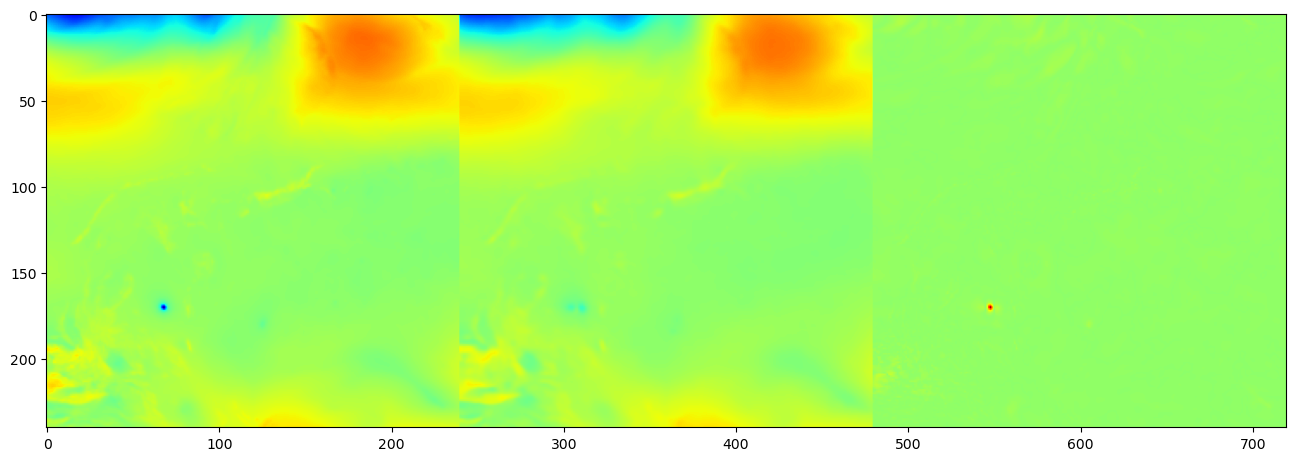

In [77]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio
import numpy as np
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(16,10))
residual = np.abs(original_data - recons_data)
video = np.concatenate([original_data, recons_data, residual], axis = -1)
video = video[1000:1018]
# video = recons_data[:,0]

im = ax.imshow(video[0], cmap="jet")

def update(frame):
    im.set_array(video[frame])
    return [im]

ani = animation.FuncAnimation(fig, update, frames=len(video), interval=1)

# Save as a GIF
ani.save("animation.gif", writer=animation.PillowWriter(fps=5))

# Display in Jupyter Notebook
HTML(ani.to_jshtml())

In [6]:
d_idx  =100
input_data, offset, scale, bbp = dataset[d_idx]
input_data.shape
cond_idx = torch.LongTensor([0,3,6,9,12,15])

pred_idx = torch.arange(input_data.shape[-3])
pred_idx = pred_idx[~torch.isin(pred_idx, cond_idx)]

In [7]:
input_data.shape

torch.Size([16, 64, 16, 16])

In [150]:
# input_data = input_data + torch.randn(input_data.shape)*0.0025

In [44]:
import matplotlib.pyplot as plt

In [45]:
plt.imshow(input_data.numpy()[0,12])

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [166]:
diffusion.zero_noise = False
images = diffusion.sample(input_data[None].cuda(),3,batch_size= 1)

sampling loop time step: 100%|██████████| 50/50 [00:01<00:00, 39.85it/s]


In [167]:
images.shape

torch.Size([1, 64, 10, 16, 16])

In [168]:
gt_img = dataset[d_idx][0].cpu().numpy()
pred_img = images[0].cpu().numpy()

print(gt_img.shape,pred_img.shape)
result_img = input_data.numpy().copy()
result_img[:,pred_idx] = pred_img
print(gt_img.shape, result_img.shape)

(64, 16, 16, 16) (64, 10, 16, 16)
(64, 16, 16, 16) (64, 16, 16, 16)


NameError: name 'gt_img' is not defined

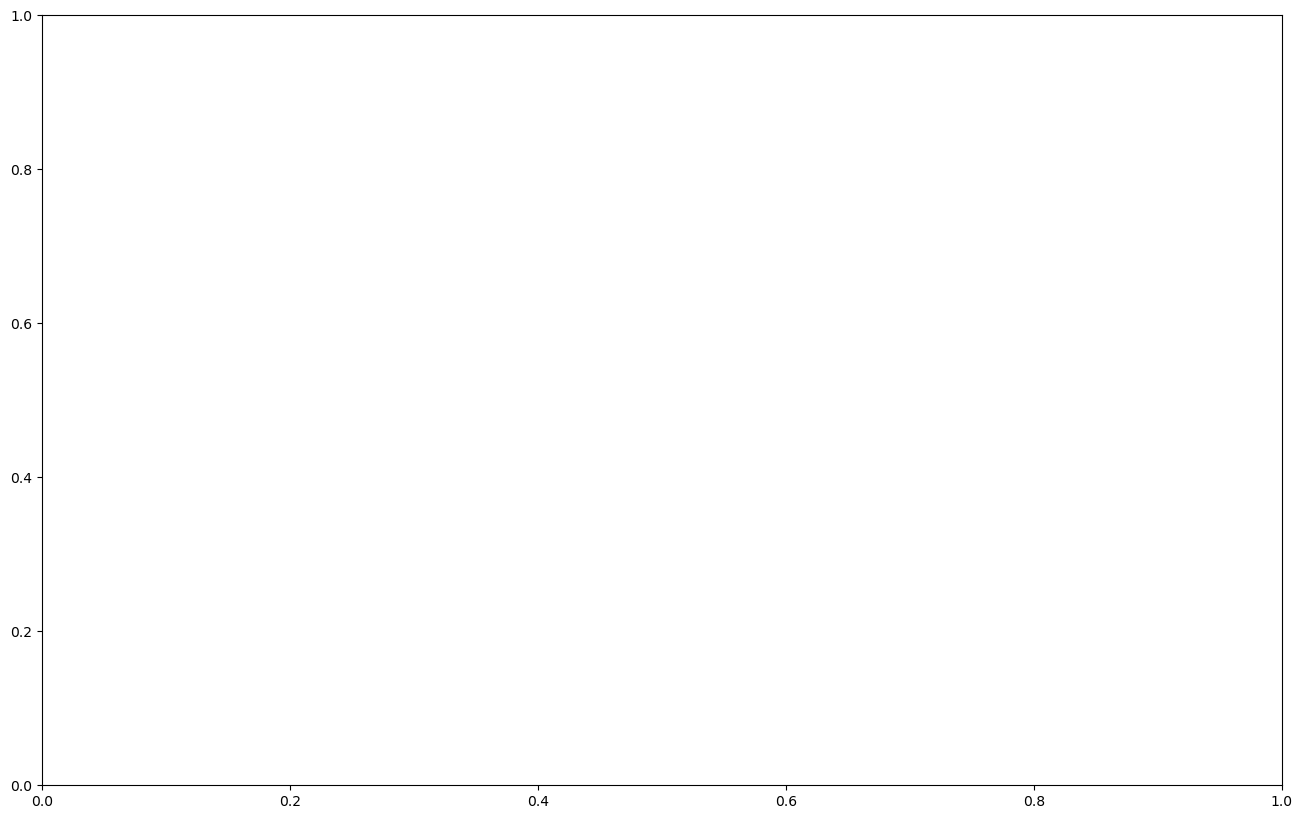

In [46]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio
import numpy as np
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(16,10))
residual = np.abs(gt_img - result_img)

video = np.concatenate([gt_img, result_img, residual], axis=-1)
video = video[0]

im = ax.imshow(video[0], cmap="jet")

def update(frame):
    im.set_array(video[frame])
    return [im]

ani = animation.FuncAnimation(fig, update, frames=len(video), interval=1)

# Save as a GIF
ani.save("animation.gif", writer=animation.PillowWriter(fps=5))

# Display in Jupyter Notebook
HTML(ani.to_jshtml())

In [119]:
from mydataset.e3sm_seq import Climate240

# results_folder = "./results/VD2_InstRange2Norm_4_16_E3SM64_OriginalDomain"

data_arg = {"data_path":"/blue/ranka/xiao.li/dataset/climate_dataset/dataset_numpy",
                        "var": [0,1,2,3,4],
                        "seq": [8],
                        "n_frame":16,
                        "downsampling":1,
                        "input_size":256,"inst_norm": False, "norm_type":'range'}

# dataset_arg = {"data_path":"./data", "n_frame":16, "inst_norm": True, "norm_type":'range2'}

dataset_org = Climate240(data_arg)

*************** Loading E3SM ***************
*************** Loading /blue/ranka/xiao.li/dataset/climate_dataset/dataset_numpy/08.npz ***************
Original Data Shape: (5, 6, 720, 240, 240)
self.data_input: (5, 6, 720, 240, 240)


In [120]:
from models.CDC import compress_modules_2d as compress_modules
import torch
import torch.nn as nn

pretrain = "./snapshots/MaskedAE/NoMask/model_bs16_ep500k.pt"
# args.pretrain = "./snapshots/MaskedAE/test/model_bs16_ep500k_final.pt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# main(args)

modelAE = compress_modules.ResnetCompressor(  dim= 16,
                                            dim_mults=[1,2,3,4],
                                            reverse_dim_mults=[4,3,2,1],
                                            hyper_dims_mults=[4,4,4],
                                            channels = 1,
                                            out_channels = 1,
                                            d3=True)

if pretrain != "":
    print("Load pretrain model:", pretrain)
    state_dict = torch.load(pretrain, map_location=device)
    modelAE.load_state_dict(state_dict)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    modelAE = nn.DataParallel(model)  # Wrap model with DataParallel for multi-GPU
else:
    print("Using a single GPU!")


modelAE = modelAE.to(device)


Load pretrain model: ./snapshots/MaskedAE/NoMask/model_bs16_ep500k.pt
Using a single GPU!


In [156]:
idx=0
latent_denorm = input_data.numpy()*scale[idx] + offset[idx]
latent_denorm = result_img*scale[idx] + offset[idx]
latent_denorm  = latent_denorm.transpose([1,0,2,3])
print(latent_denorm.shape)

latent_denorm = torch.FloatTensor(latent_denorm)
with torch.no_grad():
    recons_img_org = modelAE.decode(latent_denorm.cuda()).cpu().numpy().squeeze()

(16, 64, 16, 16)


In [157]:
gt_img_org = dataset_org[d_idx].numpy().squeeze()

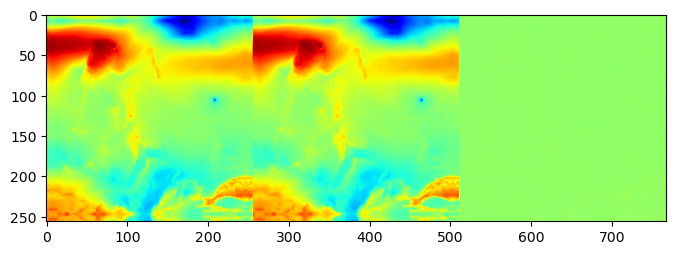

In [158]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio
import numpy as np
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(8,5))
# residual = np.abs(gt_img - result_img)

residual = np.abs(gt_img_org - recons_img_org)

video = np.concatenate([gt_img_org, recons_img_org, residual], axis=-1)

im = ax.imshow(video[0], cmap="jet")

def update(frame):
    im.set_array(video[frame])
    return [im]

ani = animation.FuncAnimation(fig, update, frames=len(video), interval=1)

# Save as a GIF
ani.save("animation.gif", writer=animation.PillowWriter(fps=5))

# Display in Jupyter Notebook
HTML(ani.to_jshtml())

In [145]:
x = gt_img_org
y = recons_img_org

error = np.sqrt(np.mean((x - y)**2, axis = (1,2)))/(x.max()-x.min())
error

array([0.00303099, 0.00384922, 0.00382713, 0.00299706, 0.00364538,
       0.00365861, 0.00305615, 0.00369157, 0.0037382 , 0.00317508,
       0.00386838, 0.00387852, 0.00321062, 0.00393009, 0.00396568,
       0.00311586], dtype=float32)

In [160]:
x = gt_img_org
y = recons_img_org

error = np.sqrt(np.mean((x - y)**2, axis = (1,2)))/(x.max()-x.min())
np.mean(error)

0.0033802846

In [189]:
np.mean([0.00378991, 0.00424436, 0.00419226, 0.0037936 , 0.00438337,
       0.00447306, 0.00394405, 0.00442877, 0.00446887, 0.00403108])

0.0041749330000000005

In [113]:
(0.0044/0.0037)*0.0012

0.001427027027027027

In [125]:

recons_path = "./data/e3sm08_psl_2d.npz"

from mydataset.e3sm240 import Climate240

# results_folder = "./results/VD2_InstRange2Norm_4_16_E3SM64_OriginalDomain"

data_arg = {"data_path":recons_path,
            "var": [0],
            "n_frame":10,
            "downsampling":1,
            "input_size":256,"inst_norm": False, "norm_type":'range'}

dataset_recons = Climate240(data_arg)

*************** Loading E3SM ***************
Original Data Shape: (1, 6, 720, 240, 240)


In [154]:
z = dataset_recons[0]['input'].numpy()*0.001

In [155]:
z.shape

(10, 256, 256)

In [156]:
error = np.sqrt(np.mean((x -z)**2, axis = (1,2)))/(x.max()-x.min())
error

array([0.11044715, 0.10714993, 0.10403642, 0.1017014 , 0.10060147,
       0.10062701, 0.10138479, 0.10247825, 0.10335634, 0.10360845],
      dtype=float32)

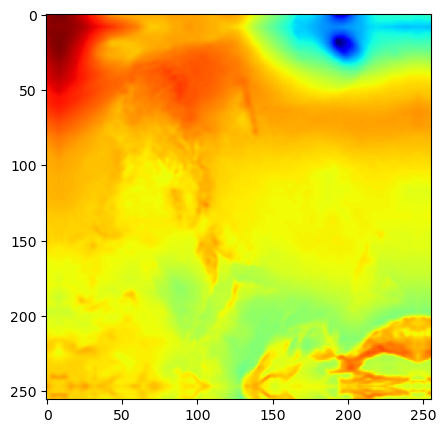

In [132]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio
import numpy as np
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(8,5))
# residual = np.abs(gt_img - result_img)

# residual = np.abs(gt_img_org - recons_img_org)

video = z 

im = ax.imshow(video[0], cmap="jet")

def update(frame):
    im.set_array(video[frame])
    return [im]

ani = animation.FuncAnimation(fig, update, frames=len(video), interval=1)

# Save as a GIF
ani.save("animation.gif", writer=animation.PillowWriter(fps=5))

# Display in Jupyter Notebook
HTML(ani.to_jshtml())